# Telecom Churn - Group Case Study

## *Problem Statement* 

### *Business Problem Overview*

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

### *Main Goals:* 

- For many incumbent operators, retaining high profitable customers is the number one business goal.
- To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### *Understanding Customer Behaviour During Churn*

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Suppressing warnings

In [459]:
# Supressing the warnings first
import warnings
warnings.filterwarnings('ignore')

### Importing Libraries

In [460]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [461]:
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [462]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [463]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

### Importing Dataset

In [464]:
# Reading the data
telecom_data = pd.read_csv('telecom_churn_data.csv')

In [465]:
#To get the idea of how the table looks like we can use .head() or .tail() command
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


### Preliminary Analysis of Data

In [466]:
# The .shape code gives the no. of rows and columns
telecom_data.shape

(99999, 226)

In [467]:
#To get an idea of the numeric values, use .describe()
telecom_data.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.0,7.001207e+09,695669.386290,7.000000e+09,7.000606e+09,7.001205e+09,7.001812e+09,7.002411e+09
circle_id,99999.0,1.090000e+02,0.000000,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
loc_og_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
std_og_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
loc_ic_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
aon,99999.0,1.219855e+03,954.733842,1.800000e+02,4.670000e+02,8.630000e+02,1.807500e+03,4.337000e+03
aug_vbc_3g,99999.0,6.817025e+01,267.580450,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.291622e+04
jul_vbc_3g,99999.0,6.683906e+01,271.201856,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.165600e+03
jun_vbc_3g,99999.0,6.002120e+01,253.938223,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116621e+04


In [468]:
# The .info() code gives almost the entire information that needs to be inspected
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [469]:
# Creating column name list by types of columns
id_cols = ['mobile_number', 'circle_id']
date_cols = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']
cat_cols =  ['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9','fb_user_6','fb_user_7','fb_user_8','fb_user_9']
num_cols = [column for column in telecom_data.columns if column not in id_cols + date_cols + cat_cols]

In [470]:
# The number of columns in each list
print("#ID cols: %d\n#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(id_cols), len(date_cols), len(num_cols), len(cat_cols)))

#ID cols: 2
#Date cols:12
#Numeric cols:204
#Category cols:8


In [471]:
# checking to see if any columnns are missed
print(len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) == telecom_data.shape[1])

True


### Missing Value Treatment

In [472]:
# looking for missing values
((telecom_data.isnull().sum()*100/telecom_data.shape[0]).round(2)).sort_values(ascending=False)

arpu_3g_6            74.85
night_pck_user_6     74.85
total_rech_data_6    74.85
arpu_2g_6            74.85
max_rech_data_6      74.85
                     ...  
max_rech_amt_7        0.00
max_rech_amt_6        0.00
total_rech_amt_9      0.00
total_rech_amt_8      0.00
sep_vbc_3g            0.00
Length: 226, dtype: float64

Since there are approx 74-75% null values for average recharge amount, max recharge data and total recharge date and date of data recharge for mobile internet data is missing.

In [473]:
# 1 is the min value for recharge column
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
                 ]

telecom_data[recharge_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,2.463802,2.666419,2.651999,2.441170,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,2.789128,3.031593,3.074987,2.516339,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,84.000000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


In [474]:
# the customer didn't recharge because the recharge date and the recharge value are missing
  
telecom_data.loc[telecom_data.total_rech_data_7.isnull() & telecom_data.date_of_last_rech_data_7.isnull(),\
          ["total_rech_data_7", "date_of_last_rech_data_7"]].head(10)

,total_rech_data_7,date_of_last_rech_data_7
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
10,NaN,NaN
11,NaN,NaN
12,NaN,NaN
13,NaN,NaN


In [475]:
# let's check if there are any values where total_rech_data is NA and value is present for av_rech_amt_data and vice versa
# check how many av_rech_amt_data_6 is NA
is_invalid_data_6 = telecom_data['av_rech_amt_data_6'] == np.nan
is_invalid_data_7 = telecom_data['av_rech_amt_data_7'] == np.nan
is_invalid_data_8 = telecom_data['av_rech_amt_data_8'] == np.nan

# check if any value is present for these rows for total_rech_data
print(telecom_data.loc[is_invalid_data_6,'total_rech_data_6'].sum())
print(telecom_data.loc[is_invalid_data_7,'total_rech_data_7'].sum())
print(telecom_data.loc[is_invalid_data_8,'total_rech_data_8'].sum())

# check how many total_rech_data_6 is NA
is_invalid_data_6 = telecom_data['total_rech_data_6'] == np.nan 
is_invalid_data_7 = telecom_data['total_rech_data_7'] == np.nan 
is_invalid_data_8 = telecom_data['total_rech_data_8'] == np.nan 

# check if any value is present for these rows for av_rech_amt_data_6
print(telecom_data.loc[is_invalid_data_6,'av_rech_amt_data_6'].sum())
print(telecom_data.loc[is_invalid_data_7,'av_rech_amt_data_7'].sum())
print(telecom_data.loc[is_invalid_data_8,'av_rech_amt_data_8'].sum())

0.0
0.0
0.0
0.0
0.0
0.0


In [476]:
#Let's impute 0 in recharge columns
zero_impute_rch = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [477]:
# Now impute missing values with 0
telecom_data[zero_impute_rch] = telecom_data[zero_impute_rch].apply(lambda x: x.fillna(0))

In [478]:
print(telecom_data[zero_impute_rch].isnull().sum()*100/telecom_data.shape[1])

total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
dtype: float64


In [479]:
#  unique values in each column
telecom_data.nunique().sort_values(ascending=False)

mobile_number       99999
arpu_6              85681
arpu_7              85308
arpu_8              83615
arpu_9              79937
                    ...  
std_og_t2c_mou_9        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_9        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_6        1
Length: 226, dtype: int64

In [480]:
# Dropping the columns 
telecom_data = telecom_data.drop(id_cols + date_cols, axis=1)
telecom_data.shape

(99999, 212)

In [481]:
# replace missing values with '-1' in categorical columns
telecom_data[cat_cols] = telecom_data[cat_cols].apply(lambda x: x.fillna(-1))

In [482]:
# Verifying the data
print("Missing value ratio:\n")
print(telecom_data[cat_cols].isnull().sum()*100/telecom_data.shape[0])

Missing value ratio:

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
night_pck_user_9    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
fb_user_9           0.0
dtype: float64


In [483]:
#Drop variables with more than a given threshold of missing values

initial_cols = telecom_data.shape[1]

MISSING_THRESHOLD = 0.7

include_cols = list(telecom_data.apply(lambda column: True if column.isnull().sum()/telecom_data.shape[0] < MISSING_THRESHOLD else False))

drop_missing = pd.DataFrame({'features':telecom_data.columns , 'include': include_cols})
drop_missing.loc[drop_missing.include == True,:]

,features,include
0,loc_og_t2o_mou,True
1,std_og_t2o_mou,True
2,loc_ic_t2o_mou,True
3,arpu_6,True
4,arpu_7,True
...,...,...
207,aon,True
208,aug_vbc_3g,True
209,jul_vbc_3g,True
210,jun_vbc_3g,True


In [484]:
# drop columns
telecom_data = telecom_data.loc[:, include_cols]

dropped_cols = telecom_data.shape[1] - initial_cols
print("{0} columns dropped.".format(dropped_cols))

-16 columns dropped.


In [485]:
# imputing the respective null columns as 0. 
telecom_data[telecom_data.select_dtypes
(exclude=['datetime64[ns]','category']).columns.tolist()] = telecom_data[telecom_data.select_dtypes
(exclude=['datetime64[ns]','category']).columns]

In [486]:
# Filter high-value customers
# Observing recharge columns
rch_td = telecom_data.columns[telecom_data.columns.str.contains('rech_amt|rech_data')]
rch_td

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6',
       'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'max_rech_data_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')

In [487]:
# null values in recharge columns
100*telecom_data.loc[:,rch_td].isnull().sum()/len(telecom_data)

total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
total_rech_amt_9      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
max_rech_amt_9        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
dtype: float64

In [488]:
telecom_data.loc[:,rch_td].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,0.619726,0.681837,0.698517,0.632806,31.792048,32.406314,33.113011,32.387644,48.445409,51.393440,52.027022,49.961089
std,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,1.760541,1.924382,1.963417,1.669040,77.248778,78.342435,78.872739,78.818696,127.743863,132.629365,131.182609,127.804280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,1.000000,1.000000,1.000000,1.000000,8.000000,14.000000,17.000000,17.000000,8.250000,17.000000,23.000000,17.000000
max,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.000000,7546.000000,4365.000000,4076.000000,4061.000000


In [489]:
telecom_data.loc[:,rch_td].head(10)

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
0,362,252,252,0,252,252,252,0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0,252.0,252.0,252.0,0.0
1,74,384,283,121,44,154,65,50,0.0,1.0,2.0,0.0,0.0,154.0,25.0,0.0,0.0,154.0,50.0,0.0
2,168,315,116,358,86,200,86,100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,46.0
3,230,310,601,410,60,50,50,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,196,350,287,200,56,110,110,50,1.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0
5,120,0,130,130,120,0,130,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,499,222,294,141,90,37,50,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1580,790,3638,0,1580,790,1580,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,437,601,120,186,90,154,30,36,0.0,2.0,3.0,0.0,0.0,154.0,23.0,0.0,0.0,177.0,69.0,0.0
9,220,195,210,180,110,154,50,130,0.0,1.0,0.0,0.0,0.0,154.0,0.0,0.0,0.0,154.0,0.0,0.0


In [490]:
# Investigation of values for june month only
rch_td_6=telecom_data.columns[telecom_data.columns.str.contains('rech_amt_6|rech_data_6|rech_amt_data_6')]
telecom_data.loc[:,rch_td_6].head(10)

,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
0,362,252,1.0,252.0,252.0
1,74,44,0.0,0.0,0.0
2,168,86,0.0,0.0,0.0
3,230,60,0.0,0.0,0.0
4,196,56,1.0,56.0,56.0
5,120,120,0.0,0.0,0.0
6,499,90,0.0,0.0,0.0
7,1580,1580,0.0,0.0,0.0
8,437,90,0.0,0.0,0.0
9,220,110,0.0,0.0,0.0


In [491]:
telecom_data.loc[:,rch_td_6].describe()

,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,327.514615,104.637486,0.619726,31.792048,48.445409
std,398.019701,120.614894,1.760541,77.248778,127.743863
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,30.000000,0.000000,0.000000,0.000000
50%,230.000000,110.000000,0.000000,0.000000,0.000000
75%,437.500000,120.000000,1.000000,8.000000,8.250000
max,35190.000000,4010.000000,61.000000,1555.000000,7546.000000


In [492]:
# Verifying percentage of null values in recharge based columns
100*telecom_data.loc[:,rch_td].isnull().sum()/len(telecom_data)

total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
total_rech_amt_9      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
max_rech_amt_9        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
dtype: float64

In [493]:
# Get the index of null vals for both columns and verify if both matches 
# if the result is false it means all rows of total_rech_data and av_rech_amt_data has null at same rows.
res = telecom_data.total_rech_data_6[telecom_data.total_rech_data_6.isna()].index != telecom_data.av_rech_amt_data_6[telecom_data.av_rech_amt_data_6.isna()].index
print('June :', res.any())
res = telecom_data.total_rech_data_7[telecom_data.total_rech_data_7.isna()].index != telecom_data.av_rech_amt_data_7[telecom_data.av_rech_amt_data_7.isna()].index
print('July :', res.any())
res = telecom_data.total_rech_data_8[telecom_data.total_rech_data_8.isna()].index != telecom_data.av_rech_amt_data_8[telecom_data.av_rech_amt_data_8.isna()].index
print('Aug :', res.any())

June : False
July : False
Aug : False


With the above test now we know that if total_rech_data is null then av_rech_amt_data is also null

### *Adding New Features*

In [494]:
# let's add a new derived variable total recharge amount for data: total_rech_amt_data
telecom_data['total_data_rech_6'] = telecom_data.total_rech_data_6 * telecom_data.av_rech_amt_data_6
telecom_data['total_data_rech_7'] = telecom_data.total_rech_data_7 * telecom_data.av_rech_amt_data_7

In [495]:
any(telecom_data.total_rech_amt_6.isna())

False

In [496]:
any(telecom_data.total_rech_amt_7.isna())

False

In [497]:
# Total recharge amount for June and July 
telecom_data['amt_data_6'] = telecom_data.total_rech_amt_6 + telecom_data.total_data_rech_6
telecom_data['amt_data_7'] = telecom_data.total_rech_amt_7 + telecom_data.total_data_rech_7

In [498]:
# average recharge done by customer in June and July
telecom_data['av_amt_data_6_7'] = (telecom_data.amt_data_6 + telecom_data.amt_data_7)/2

In [499]:
telecom_data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7
0,0.0,0.0,0.0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,...,968,30.4,0.0,101.20,3.58,252.0,252.0,614.0,504.0,559.0
1,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,7.68,...,1006,0.0,0.0,0.00,0.00,0.0,154.0,74.0,538.0,306.0
2,0.0,0.0,0.0,167.690,189.058,210.226,290.714,11.54,55.24,37.26,...,1103,0.0,0.0,4.17,0.00,0.0,0.0,168.0,315.0,241.5
3,0.0,0.0,0.0,221.338,251.102,508.054,389.500,99.91,54.39,310.98,...,2491,0.0,0.0,0.00,0.00,0.0,0.0,230.0,310.0,270.0
4,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,83.89,...,1526,0.0,0.0,0.00,0.00,56.0,0.0,252.0,350.0,301.0


In [500]:
telecom_data[['av_amt_data_6_7', 'total_data_rech_6', 'total_data_rech_7', 'amt_data_6', 'amt_data_7']].head()

,av_amt_data_6_7,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7
0,559.0,252.0,252.0,614.0,504.0
1,306.0,0.0,154.0,74.0,538.0
2,241.5,0.0,0.0,168.0,315.0
3,270.0,0.0,0.0,230.0,310.0
4,301.0,56.0,0.0,252.0,350.0


### *High Value Customers*

In [501]:
#Filter high-value customers
#Define high-value customers as follows:

#Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount 

In [502]:
# 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(telecom_data.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 478.0


In [503]:
# Extracting High value customers where total average recharge amount for good phase > 70th percentile
high_val_cust = telecom_data.loc[telecom_data.av_amt_data_6_7 > telecom_data.av_amt_data_6_7.quantile(0.7), :]
high_val_cust = high_val_cust.reset_index(drop=True)
high_val_cust.shape

(29953, 201)

In [504]:
print("Number of rows before filtering the high value customers =", len(telecom_data))

Number of rows before filtering the high value customers = 99999


In [505]:
print("Number of rows after filtering the high value customers =", len(high_val_cust))

Number of rows after filtering the high value customers = 29953


In [506]:
# delete variables created to filter high-value customers
high_val_cust = high_val_cust.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)
high_val_cust.shape

(29953, 196)

In [507]:
high_val_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29953 entries, 0 to 29952
Columns: 196 entries, loc_og_t2o_mou to sep_vbc_3g
dtypes: float64(163), int64(33)
memory usage: 44.8 MB


### *Churn Derivation*

In [508]:
# total incoming and outgoing minutes of usage
high_val_cust['total_calls_mou_9'] = high_val_cust.total_ic_mou_9 + high_val_cust.total_og_mou_9

In [509]:
# 2g and 3g data consumption
high_val_cust['total_internet_mb_9'] =  high_val_cust.vol_2g_mb_9 + high_val_cust.vol_3g_mb_9

Tag churners and remove attributes of the churn phase
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: 
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.

The attributes you need to use to tag churners are:

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [510]:
# Those who have not used either calls or internet in  September are churned customers

# Let's denote 0 as not churn and  1 as churn
high_val_cust['churn'] = high_val_cust.apply(lambda row: 1 if (row.total_calls_mou_9 == 0 and row.total_internet_mb_9 == 0) else 0, axis=1)

In [511]:
# verify that the churn is tagged correctly
high_val_cust[['churn','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]

,churn,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,1,0.00,0.00,0.00,0.00
1,1,0.00,0.00,0.00,0.00
2,0,34.91,142.18,0.00,0.00
3,0,252.61,1031.53,0.00,0.00
4,0,127.48,127.63,13.93,314.74
...,...,...,...,...,...
29948,0,391.63,64.21,0.00,0.00
29949,0,149.26,14.44,723.41,232.56
29950,0,547.11,1095.24,9.14,941.48
29951,0,265.84,182.16,0.05,393.34


After defining the y variable by tagging churners delete the columns having _9 attribute in their name

After tagging churners, remove all the attributes corresponding to the churn phase

(all attributes having ‘ _9’, etc. in their names).

Get the list of columns which has name ends with _9 attribute

In [512]:
# find the columns which has name ends with _9 attribute
month_9_cols = high_val_cust.columns[high_val_cust.columns.str.endswith(pat = '_9')]
print("The columns names ends with _9 are given below...")
month_9_cols

The columns names ends with _9 are given below...


Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9',
       'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9',
       'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9',
       'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'night_pck_user_9',
       'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9',
       'fb_user_9', 'total_calls_mou_9', 'total_internet_mb_9'],
      dtype='object')

In [513]:
# so, deleting derived variables
high_val_cust = high_val_cust.drop(['total_calls_mou_9', 'total_internet_mb_9'], axis=1)

In [514]:
# change data type to category
high_val_cust.churn = high_val_cust.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(high_val_cust.churn.value_counts()*100/high_val_cust.shape[0])

Churn Ratio:
0    91.877274
1     8.122726
Name: churn, dtype: float64


#### We see that approx. 8.1% of high value customers have churned

calculate difference variable as the difference between 8th month and the average of 6th and 7th month.

In [515]:
high_val_cust['arpu_diff'] = high_val_cust.arpu_8 - ((high_val_cust.arpu_6 + high_val_cust.arpu_7)/2)

high_val_cust['onnet_mou_diff'] = high_val_cust.onnet_mou_8 - ((high_val_cust.onnet_mou_6 + high_val_cust.onnet_mou_7)/2)

high_val_cust['offnet_mou_diff'] = high_val_cust.offnet_mou_8 - ((high_val_cust.offnet_mou_6 + high_val_cust.offnet_mou_7)/2)

high_val_cust['roam_ic_mou_diff'] = high_val_cust.roam_ic_mou_8 - ((high_val_cust.roam_ic_mou_6 + high_val_cust.roam_ic_mou_7)/2)

high_val_cust['roam_og_mou_diff'] = high_val_cust.roam_og_mou_8 - ((high_val_cust.roam_og_mou_6 + high_val_cust.roam_og_mou_7)/2)

high_val_cust['loc_og_mou_diff'] = high_val_cust.loc_og_mou_8 - ((high_val_cust.loc_og_mou_6 + high_val_cust.loc_og_mou_7)/2)

high_val_cust['std_og_mou_diff'] = high_val_cust.std_og_mou_8 - ((high_val_cust.std_og_mou_6 + high_val_cust.std_og_mou_7)/2)

high_val_cust['isd_og_mou_diff'] = high_val_cust.isd_og_mou_8 - ((high_val_cust.isd_og_mou_6 + high_val_cust.isd_og_mou_7)/2)

high_val_cust['spl_og_mou_diff'] = high_val_cust.spl_og_mou_8 - ((high_val_cust.spl_og_mou_6 + high_val_cust.spl_og_mou_7)/2)

high_val_cust['total_og_mou_diff'] = high_val_cust.total_og_mou_8 - ((high_val_cust.total_og_mou_6 + high_val_cust.total_og_mou_7)/2)

high_val_cust['loc_ic_mou_diff'] = high_val_cust.loc_ic_mou_8 - ((high_val_cust.loc_ic_mou_6 + high_val_cust.loc_ic_mou_7)/2)

high_val_cust['std_ic_mou_diff'] = high_val_cust.std_ic_mou_8 - ((high_val_cust.std_ic_mou_6 + high_val_cust.std_ic_mou_7)/2)

high_val_cust['isd_ic_mou_diff'] = high_val_cust.isd_ic_mou_8 - ((high_val_cust.isd_ic_mou_6 + high_val_cust.isd_ic_mou_7)/2)

high_val_cust['spl_ic_mou_diff'] = high_val_cust.spl_ic_mou_8 - ((high_val_cust.spl_ic_mou_6 + high_val_cust.spl_ic_mou_7)/2)

high_val_cust['total_ic_mou_diff'] = high_val_cust.total_ic_mou_8 - ((high_val_cust.total_ic_mou_6 + high_val_cust.total_ic_mou_7)/2)

high_val_cust['total_rech_num_diff'] = high_val_cust.total_rech_num_8 - ((high_val_cust.total_rech_num_6 + high_val_cust.total_rech_num_7)/2)

high_val_cust['total_rech_amt_diff'] = high_val_cust.total_rech_amt_8 - ((high_val_cust.total_rech_amt_6 + high_val_cust.total_rech_amt_7)/2)

high_val_cust['max_rech_amt_diff'] = high_val_cust.max_rech_amt_8 - ((high_val_cust.max_rech_amt_6 + high_val_cust.max_rech_amt_7)/2)

high_val_cust['total_rech_data_diff'] = high_val_cust.total_rech_data_8 - ((high_val_cust.total_rech_data_6 + high_val_cust.total_rech_data_7)/2)

high_val_cust['max_rech_data_diff'] = high_val_cust.max_rech_data_8 - ((high_val_cust.max_rech_data_6 + high_val_cust.max_rech_data_7)/2)

high_val_cust['av_rech_amt_data_diff'] = high_val_cust.av_rech_amt_data_8 - ((high_val_cust.av_rech_amt_data_6 + high_val_cust.av_rech_amt_data_7)/2)

high_val_cust['vol_2g_mb_diff'] = high_val_cust.vol_2g_mb_8 - ((high_val_cust.vol_2g_mb_6 + high_val_cust.vol_2g_mb_7)/2)

high_val_cust['vol_3g_mb_diff'] = high_val_cust.vol_3g_mb_8 - ((high_val_cust.vol_3g_mb_6 + high_val_cust.vol_3g_mb_7)/2)

In [516]:
high_val_cust['total_og_mou_diff'].describe()

count    29953.000000
mean       -67.461292
std        502.520398
min      -7213.410000
25%       -167.865000
50%        -14.625000
75%         67.915000
max      12768.705000
Name: total_og_mou_diff, dtype: float64

In [517]:
#  9th Month (churned month) Columns
col_9 =  high_val_cust.columns[high_val_cust.columns.str.contains('_9')]

In [518]:
#  all names ending with 9
col_9 = high_val_cust.filter(regex='9$', axis=1).columns

# update num_cols and cat_cols column name list
cat_cols = [col for col in cat_cols if col not in col_9]
cat_cols.append('churn')
num_cols = [col for col in high_val_cust.columns if col not in cat_cols]

In [519]:
# change column types
high_val_cust[num_cols] = high_val_cust[num_cols].apply(pd.to_numeric)
high_val_cust[cat_cols] = high_val_cust[cat_cols].apply(lambda column: column.astype("category"), axis=0)

## Exploratory Data Analysis 

In [520]:
#  plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(x=var1, y=var2)

count    99999.000000
mean       282.987358
std        328.439770
min      -2258.709000
25%         93.411500
50%        197.704000
75%        371.060000
max      27731.088000
Name: arpu_6, dtype: float64


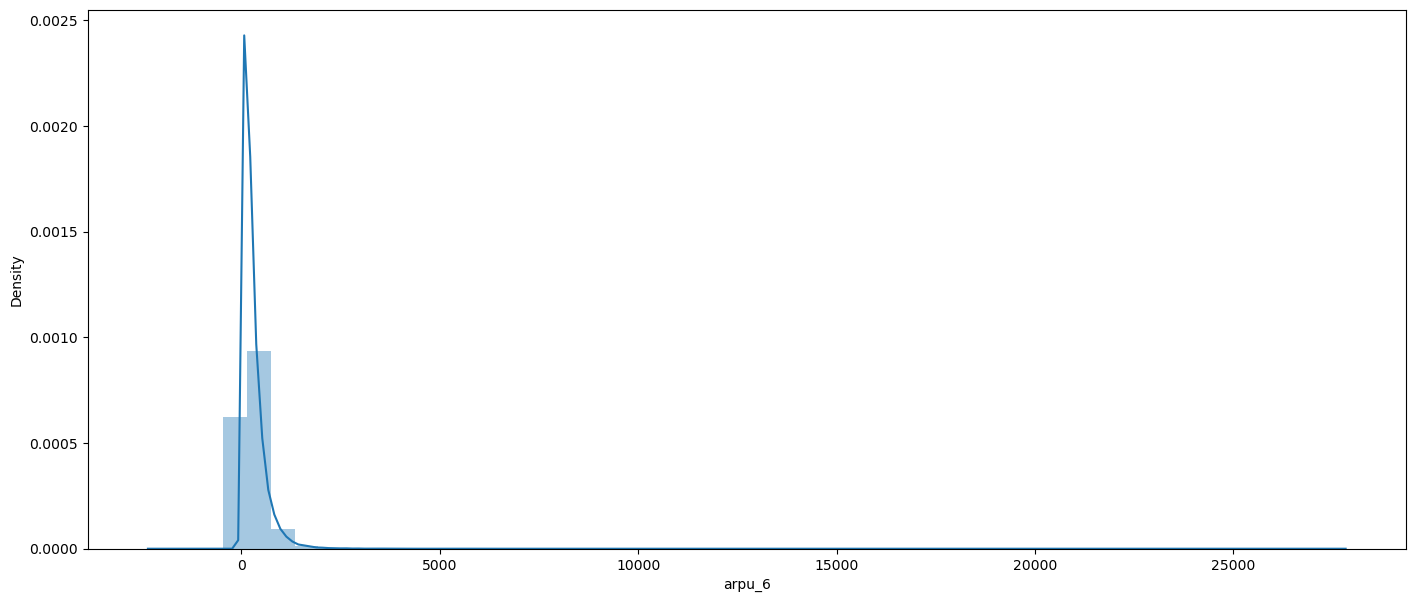

In [521]:
univariate(telecom_data.arpu_6)

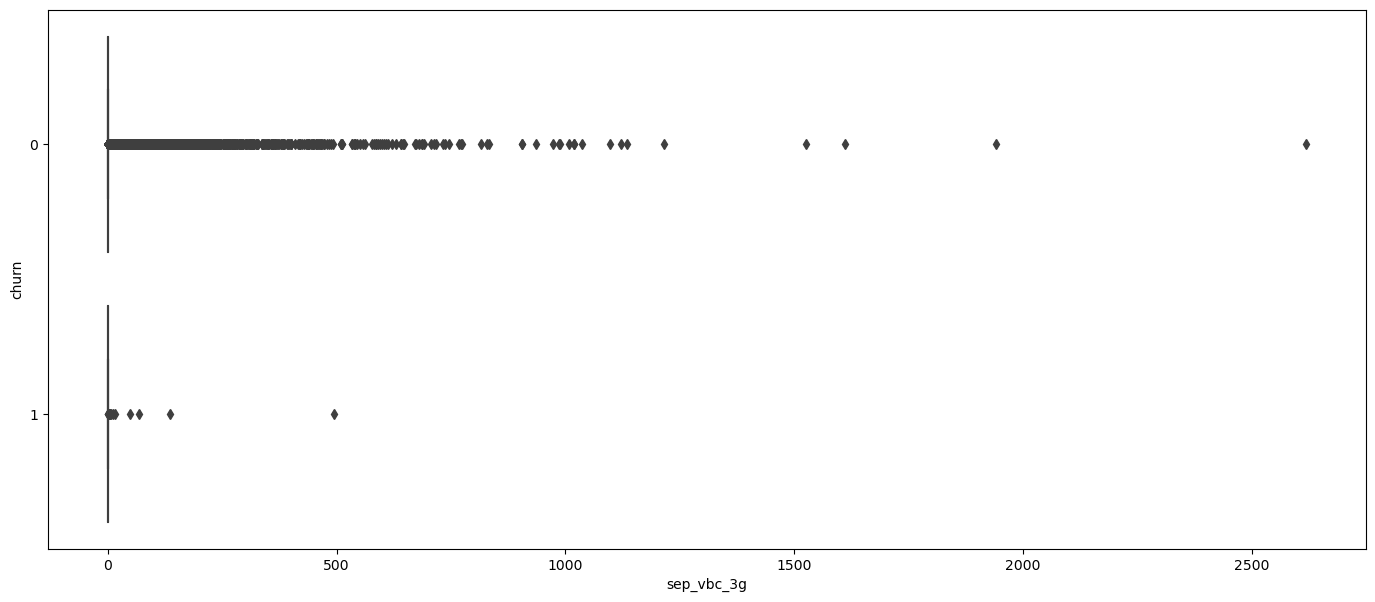

In [522]:
bivariate(high_val_cust.sep_vbc_3g, high_val_cust.churn)

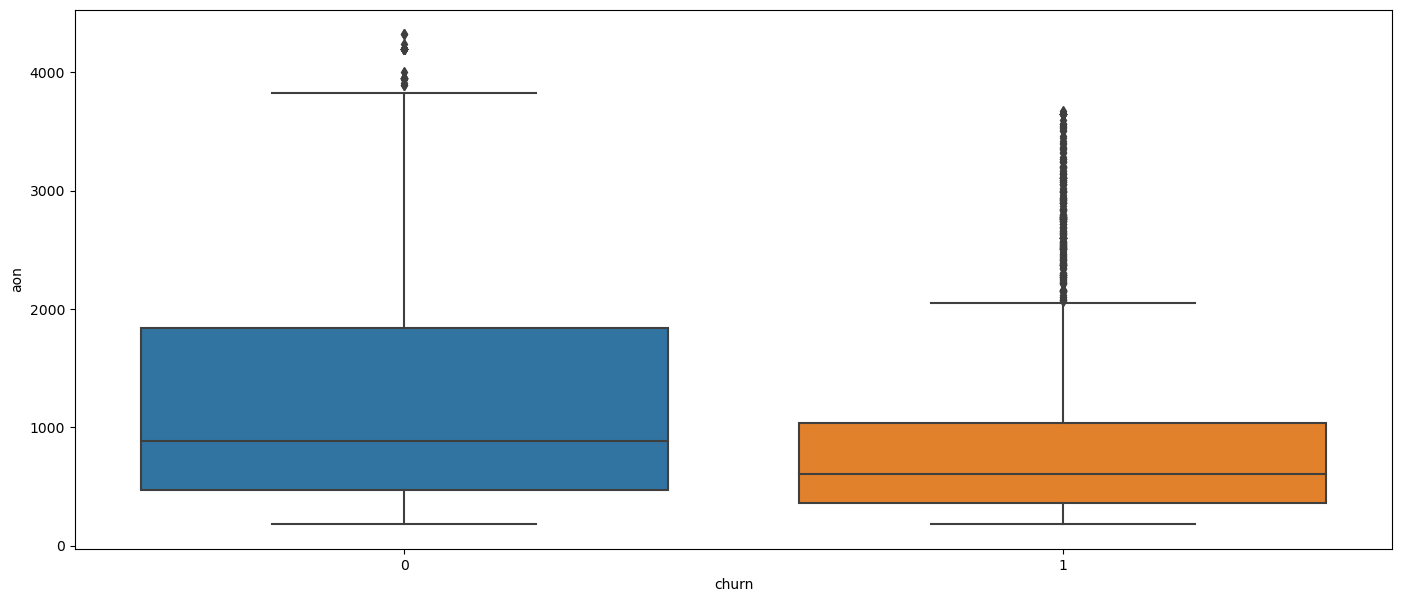

In [523]:
bivariate(high_val_cust.churn, high_val_cust.aon)

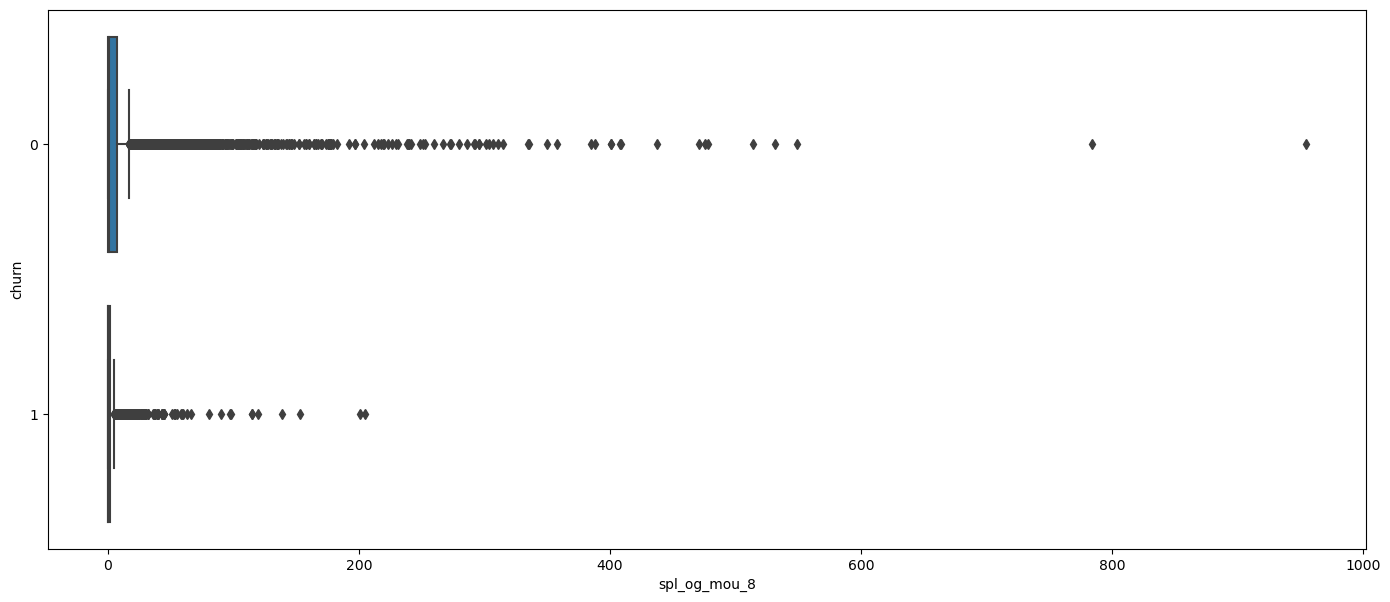

In [524]:
bivariate(high_val_cust.spl_og_mou_8, high_val_cust.churn)

count    92254.000000
mean       190.337222
std        319.396092
min          0.000000
25%         27.130000
50%         87.290000
75%        220.505000
max      10310.760000
Name: offnet_mou_9, dtype: float64


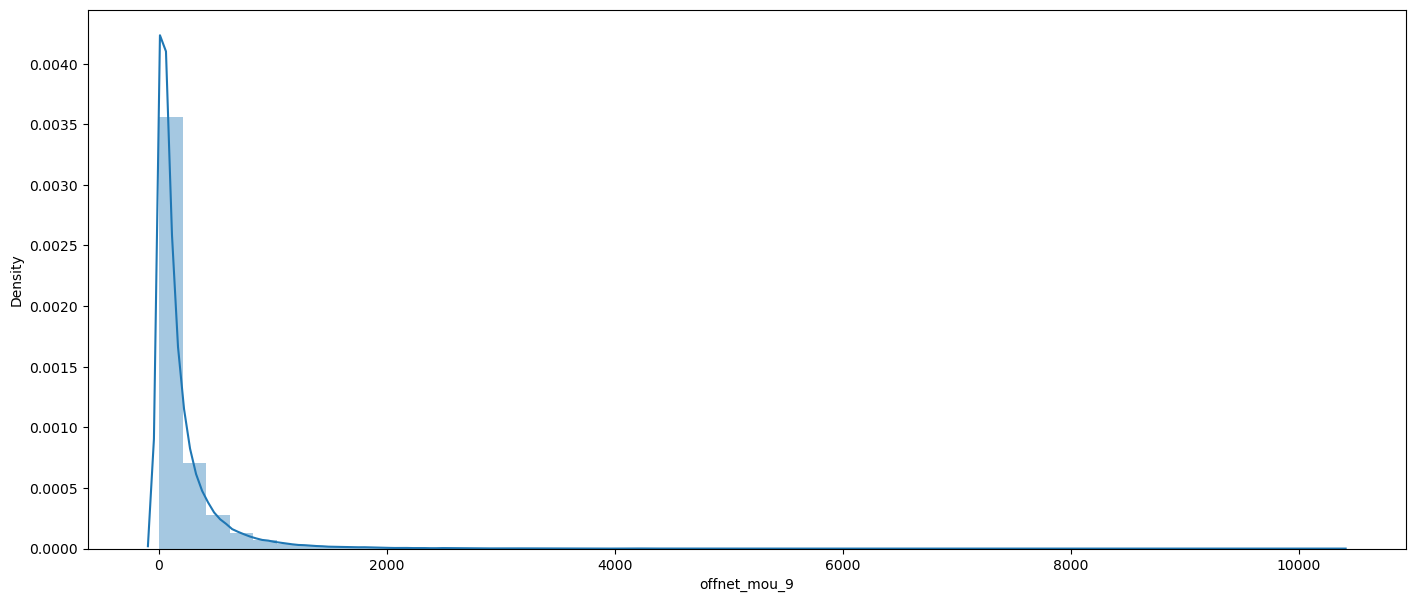

In [525]:
univariate(telecom_data.offnet_mou_9)

count    94621.000000
mean       133.018098
std        308.951589
min          0.000000
25%          6.460000
50%         32.360000
75%        115.860000
max      10752.560000
Name: onnet_mou_8, dtype: float64


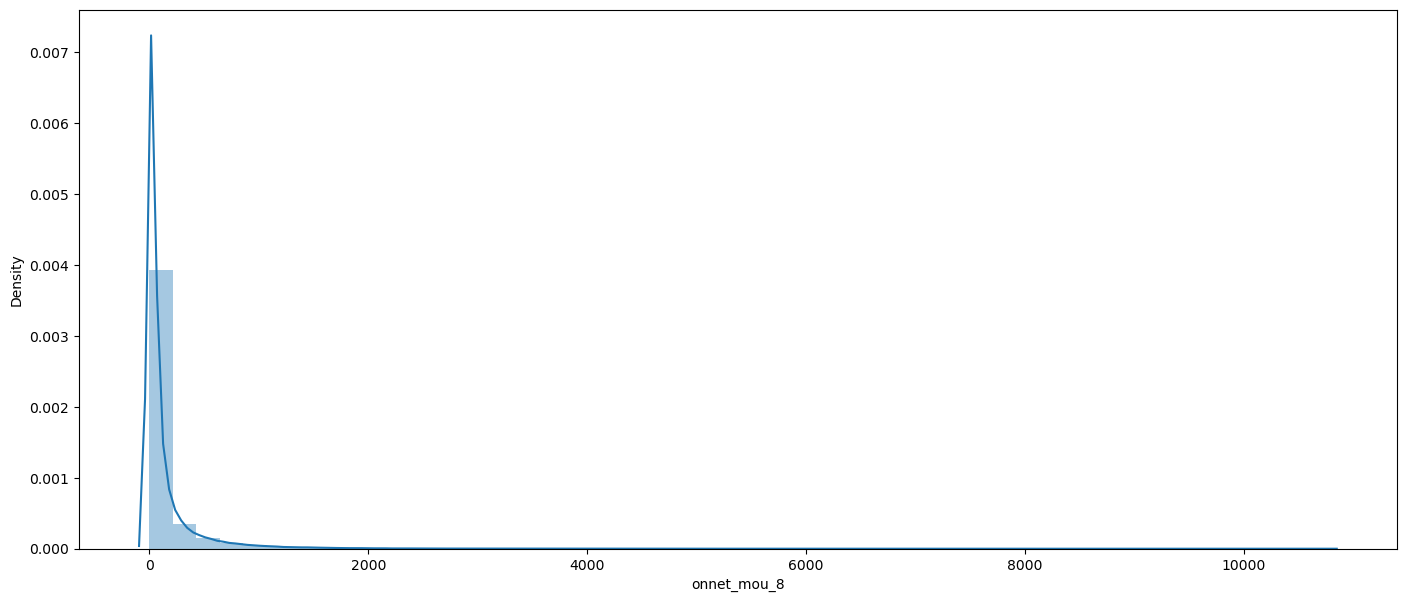

In [526]:
univariate(telecom_data.onnet_mou_8)

In [527]:
high_val_cust.columns

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8',
       ...
       'spl_ic_mou_diff', 'total_ic_mou_diff', 'total_rech_num_diff',
       'total_rech_amt_diff', 'max_rech_amt_diff', 'total_rech_data_diff',
       'max_rech_data_diff', 'av_rech_amt_data_diff', 'vol_2g_mb_diff',
       'vol_3g_mb_diff'],
      dtype='object', length=220)

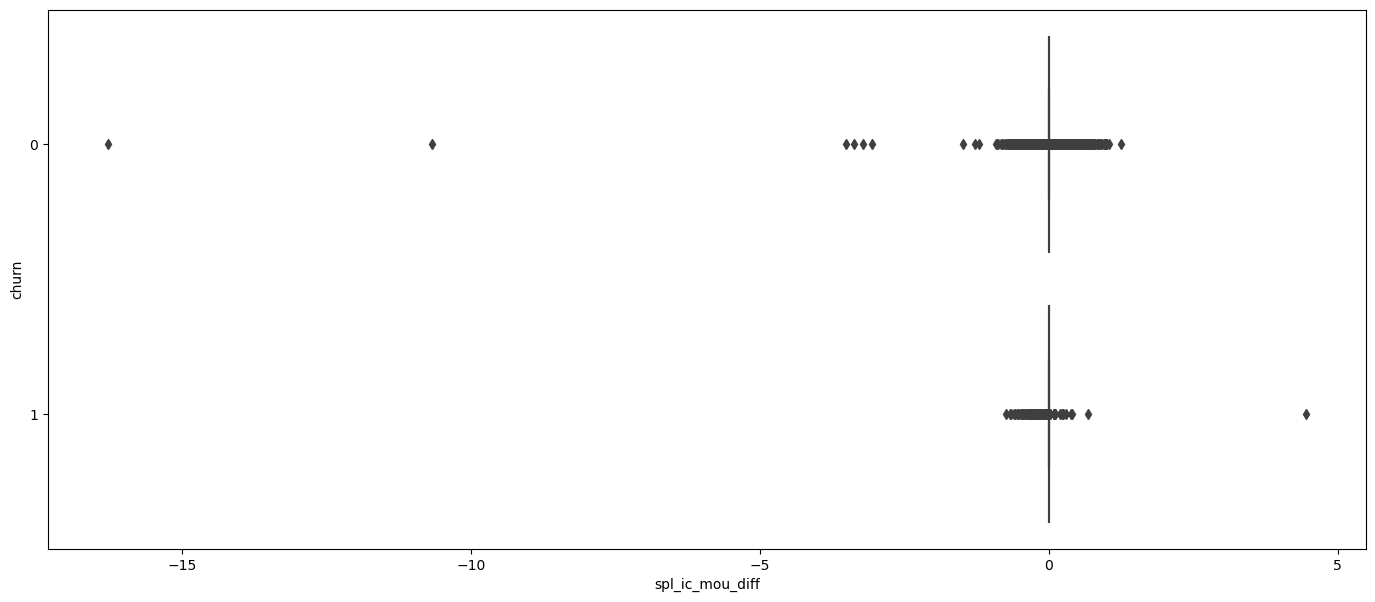

In [528]:
bivariate(high_val_cust.spl_ic_mou_diff, high_val_cust.churn)

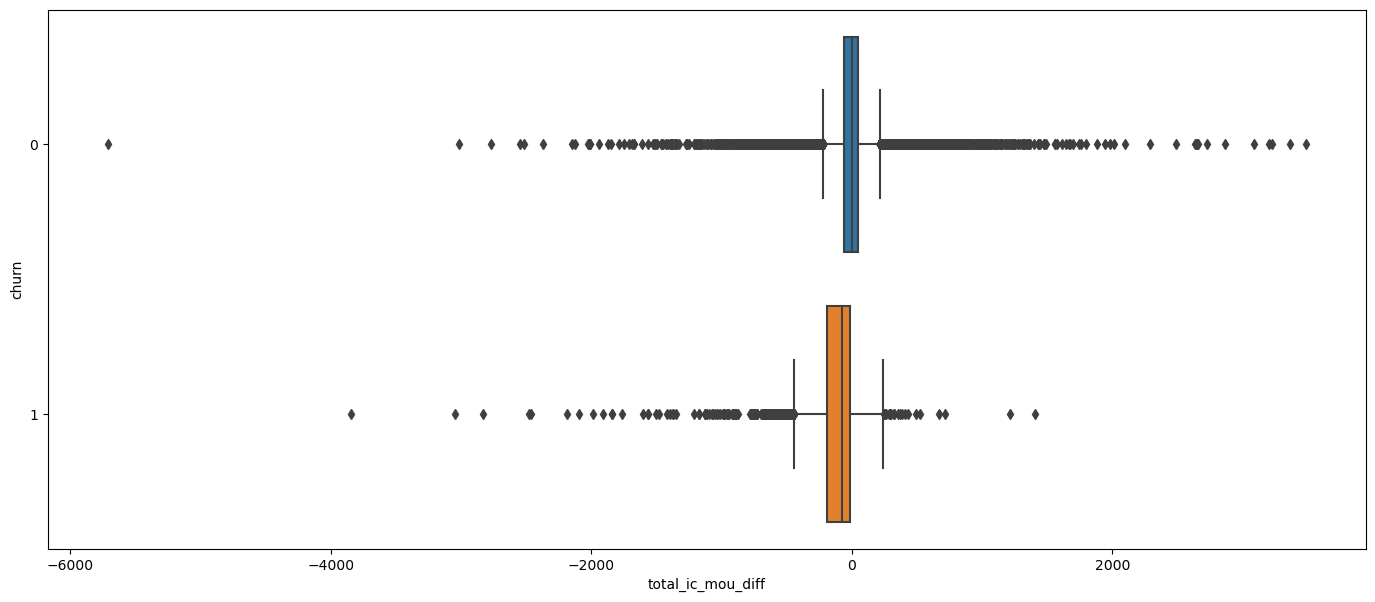

In [529]:
bivariate(high_val_cust.total_ic_mou_diff, high_val_cust.churn)

In [530]:
print('Summary metrics - Numeric Variables')

numeric_df = (high_val_cust.iloc[:,0:20])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,20:40])._get_numeric_data()
print(numeric_df.describe())
  
numeric_df = (high_val_cust.iloc[:,40:60])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,60:80])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,80:100])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,100:120])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,120:140])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (high_val_cust.iloc[:,140:160])._get_numeric_data()
print(numeric_df.describe())

Summary metrics - Numeric Variables
       loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count         29730.0         29730.0         29730.0  29953.000000   
mean              0.0             0.0             0.0    558.820058   
std               0.0             0.0             0.0    460.868223   
min               0.0             0.0             0.0  -2258.709000   
25%               0.0             0.0             0.0    310.142000   
50%               0.0             0.0             0.0    482.354000   
75%               0.0             0.0             0.0    700.240000   
max               0.0             0.0             0.0  27731.088000   

             arpu_7        arpu_8        arpu_9   onnet_mou_6   onnet_mou_7  \
count  29953.000000  29953.000000  29953.000000  29411.000000  29417.000000   
mean     561.160547    508.890301    467.446183    265.708886    272.935850   
std      480.028497    502.136278    501.837624    462.692744    483.282132   
min    -

## EDA - Summary

### Calls Revenue(3 columns):
- Invalid Values : Having minimum values as negatives, indicating some customers are making loss to the company. These columns are either invalid or not adding value to our prediction, can be dropped from the dataset.

- Standardise: Revenue columns can be rounded to 2 decimal places.

- Minutes of usage(60+ columns):
- Usage minutes is generally 0 except for few outliers, for below variables:
- Roaming Incoming ISD Incoming Special Incoming Others STD incoming T2F STD outgoing T2F Outgoing Others ISD Outgoing Local Outgoing T2C (Customer care calls)

- Most of the columns have outliers.

### Aggregating Columns based on Incoming and Outgoing, or Aggregating based on Each Type of Incoming Calls and Outgoing Calls and looking at the metrics will give a better understanding of the data.

- Recharge (12 Numeric + 3 Date columns)
- Data Type Conversion:

- Data in numeric columns are integers, so can be converted to int type.
- Date columns need to be converted to date type
- Data 2G And 3G(22 Columns)
- Most of the columns have median as O and have outliers

- vbc_3g columns need column renaming as it needs month to be encoded to its number.

- Standardise: Columns can be rounded off to 2 decimal places.

- Age on Network (1 Column)
- Feature can be derived from AON column.

- Churn (Dependent Variable)
- There exists a Class Imbalance in the dataset, where actual churn customers are only 6% of the dataset.

### Reviewing the Dropped Columns:
- More columns will be lost because of dropping missing value columns, while it can be handled to be imputed by considered 0 as missing values follow a pattern where Calls only users have blanks for Data related columns and the vice versa.

### Feature Engineering - Thoughts
- Derive no. of years the customer is using network from AON
- Derive fields to indicate the type of user the customer is: Uses Both Calls and Data, Only Calls, Only Data, Only Incoming calls, Only Outgoing calls, etc.
- Bin the customers into different segments based on Service usage, Recharge amount, Usage/Recharge pattern.
- Calls to Customer Care is a Key indicator that customer is not happy with the services, derive columns like time over call

In [531]:
# create function to anlyze the features across 6th, 7th and 8th month
def analyze_feature(feature_start):
    plt.rcParams["figure.figsize"] = [17, 7]
    fig = plt.figure()
    print("Churn Stats (mean and standard deviation):")
    cols = {c: feature_start + "_" + str(c) for c in [6,7,8]}
    print(cols)
    frame_data = []
    [frame_data.append({
        "mean_6": high_val_cust[high_val_cust["churn"] == churn][cols[6]].mean(),
        "mean_7": high_val_cust[high_val_cust["churn"] == churn][cols[7]].mean(),
        "mean_8": high_val_cust[high_val_cust["churn"] == churn][cols[8]].mean(),
        "std_6": high_val_cust[high_val_cust["churn"] == churn][cols[6]].std(),
        "std_7": high_val_cust[high_val_cust["churn"] == churn][cols[7]].std(),
        "std_8": high_val_cust[high_val_cust["churn"] == churn][cols[8]].std()
    }) for churn in [0,1]]
    
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=high_val_cust, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0])
    sns.boxplot(data=high_val_cust, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1])
    sns.boxplot(data=high_val_cust, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2])
    return pd.DataFrame(frame_data,index=("Non Churned","Churned")).round(2)

Churn Stats (mean and standard deviation):
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,649.97,663.89,613.98,547.95,574.45,615.04
Churned,787.33,627.46,253.69,682.48,668.66,452.97


<Figure size 1700x700 with 0 Axes>

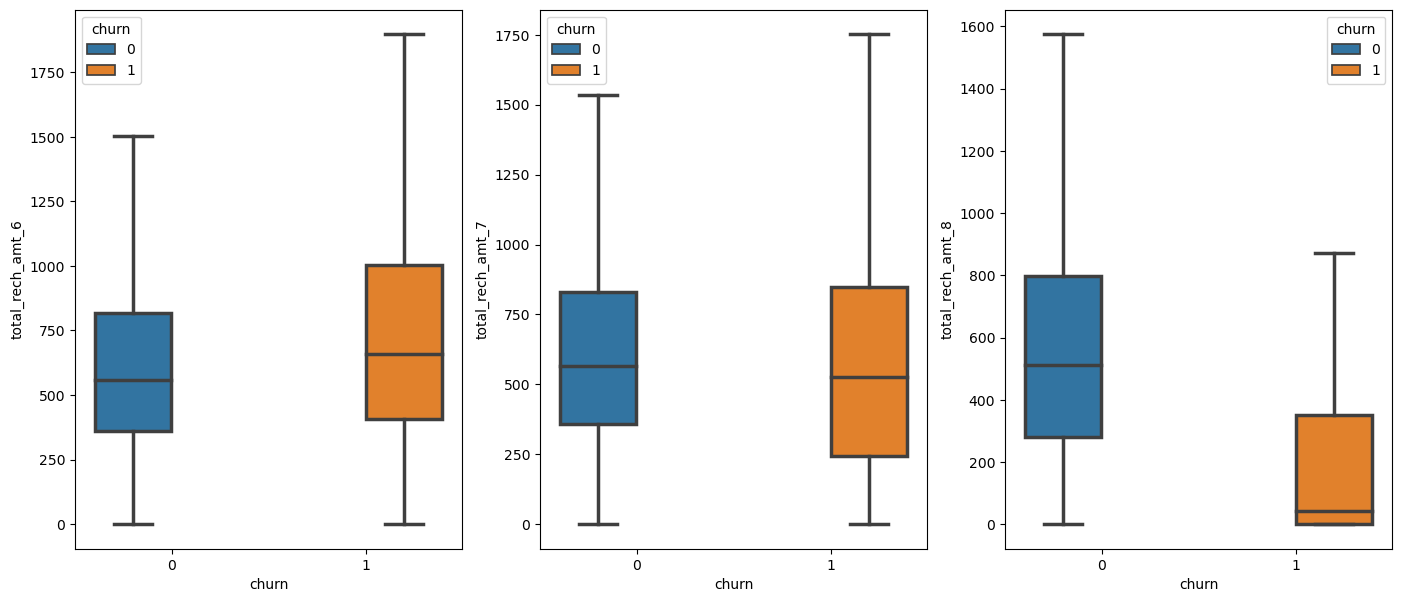

In [532]:
analyze_feature('total_rech_amt')

In [533]:
recharge_amnt_columns =  high_val_cust.columns[high_val_cust.columns.str.contains('rech_amt')]

recharge_amnt_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
       'total_rech_amt_diff', 'max_rech_amt_diff', 'av_rech_amt_data_diff'],
      dtype='object')

Churn Stats (mean and standard deviation):
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


,mean_6,mean_7,mean_8,std_6,std_7,std_8
Non Churned,169.10,173.40,166.83,172.1,176.85,171.42
Churned,172.18,159.66,85.54,209.4,227.28,176.90


<Figure size 1700x700 with 0 Axes>

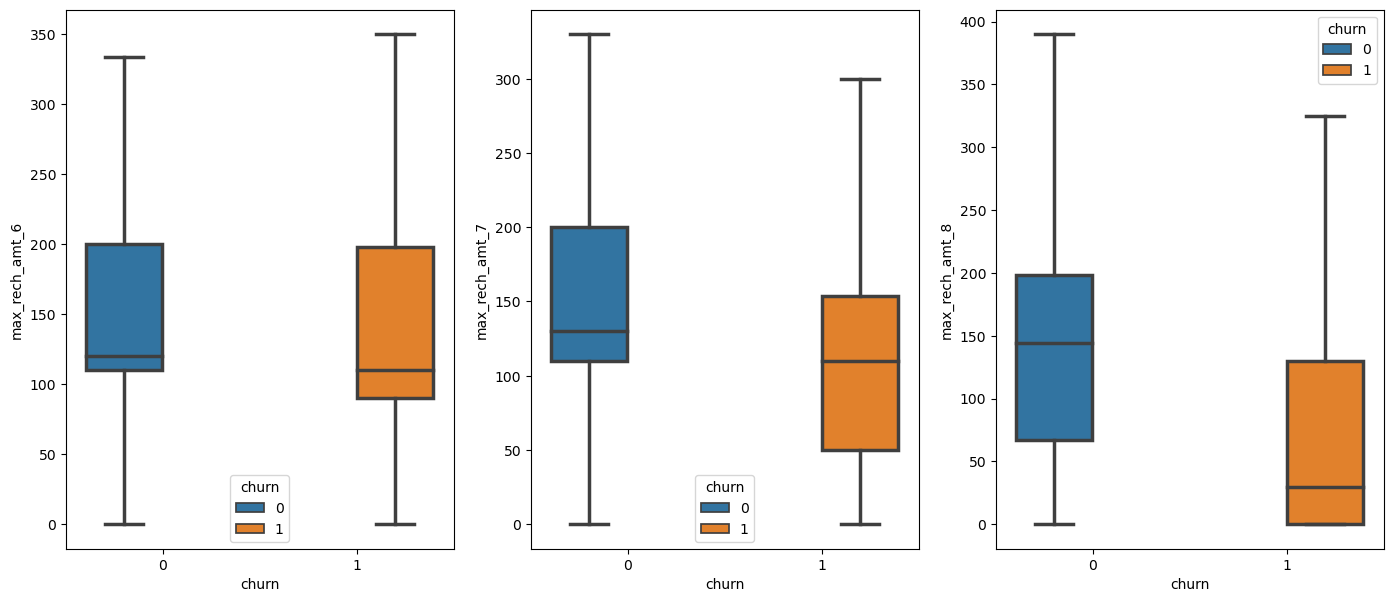

In [534]:
# let's analyze total recharge amount for data:
analyze_feature('max_rech_amt')

In [535]:
pd.crosstab(high_val_cust.churn, high_val_cust.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0,85.918105,97.114275,97.360704
1,14.081895,2.885725,2.639296


In [536]:
pd.crosstab(high_val_cust.churn, high_val_cust.sachet_3g_8)

sachet_3g_8,0,1,2,3,4,5,6,7,8,9,...,19,20,21,23,25,27,29,30,38,41
churn,,,,,,,,,,,,,,,,,,,,,
0,24936,1608,397,183,106,86,43,35,28,19,...,1,3,3,2,1,1,1,2,1,1
1,2361,48,5,8,4,2,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [537]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

### *Capping Example*

In [538]:
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [539]:
# cap outliers in the numeric columns
high_val_cust[num_cols] = high_val_cust[num_cols].apply(cap_outliers, axis=0)

In [540]:
high_val_cust.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,spl_ic_mou_diff,total_ic_mou_diff,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
count,29730.0,29730.0,29730.0,29953.000000,29953.000000,29953.000000,29953.000000,29411.000000,29417.000000,28781.000000,...,28460.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,0.0,0.0,0.0,548.514161,551.188115,498.725003,457.829622,249.407606,256.359700,226.325749,...,-0.013605,-12.939341,-1.775336,-77.417346,-9.024191,-0.151190,-6.310569,-13.370373,-20.378957,-9.405241
std,0.0,0.0,0.0,356.773582,361.289210,384.542031,381.720503,374.743643,391.079643,361.885853,...,0.119509,172.824139,5.868286,361.358189,101.273135,1.819270,68.289357,126.503797,187.616192,454.108531
min,0.0,0.0,0.0,-823.784610,-878.924945,-945.808000,-1038.066688,0.000000,0.000000,0.000000,...,-0.548291,-679.434403,-22.081196,-1331.865709,-421.513514,-6.785967,-241.610728,-457.948931,-788.613826,-1881.452483
1%,0.0,0.0,0.0,1.272400,0.726000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.380000,-679.434403,-22.081196,-1207.920000,-421.513514,-6.785967,-241.610728,-449.000000,-788.613826,-1727.872000
10%,0.0,0.0,0.0,171.795000,177.973000,84.302800,23.000000,1.650000,1.406000,0.650000,...,-0.130000,-174.505000,-8.000000,-506.000000,-109.500000,-2.000000,-88.500000,-152.000000,-168.475000,-384.172000
25%,0.0,0.0,0.0,310.142000,310.071000,231.615000,189.750000,19.250000,18.180000,14.280000,...,0.000000,-67.220000,-4.000000,-245.000000,-33.000000,-0.500000,-7.000000,-60.000000,-21.155000,-2.395000
50%,0.0,0.0,0.0,482.354000,481.496000,427.604000,388.093000,88.140000,86.890000,72.990000,...,0.000000,-5.610000,-1.500000,-57.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,700.240000,698.829000,661.753000,626.637000,297.490000,298.380000,255.310000,...,0.000000,44.295000,1.000000,99.500000,25.000000,0.000000,0.000000,9.500000,0.000000,0.000000
90%,0.0,0.0,0.0,994.408600,996.170600,977.546400,935.926600,765.090000,795.266000,686.940000,...,0.000000,141.817000,4.500000,301.000000,71.000000,1.500000,50.000000,116.000000,68.267000,312.172000


## Model Building

In [541]:
high_val_cust_new=high_val_cust.dropna()

In [542]:
#building the model now

# got numeric from
high_val_cust_new['churn'] = pd.to_numeric(high_val_cust_new['churn'])

In [543]:
X = high_val_cust_new.drop("churn", axis = 1)
y = high_val_cust_new.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [544]:
train = pd.concat([X_train, y_train], axis=1)

# aggregate the categorical variables
train.groupby('night_pck_user_6').churn.mean()
train.groupby('night_pck_user_7').churn.mean()
train.groupby('night_pck_user_8').churn.mean()
train.groupby('fb_user_6').churn.mean()
train.groupby('fb_user_7').churn.mean()
train.groupby('fb_user_8').churn.mean()

fb_user_8
-1.0    0.050251
0.0     0.039232
1.0     0.004744
Name: churn, dtype: float64

In [545]:
y_test.shape

(6897,)

In [546]:
 y_train.shape

(20690,)

In [547]:
X_train.shape

(20690, 219)

In [548]:
X_test.shape

(6897, 219)

## Class Imbalance

In [549]:
# Ratio of classes 
class_0 = y[y == 0].count()
class_1 = y[y == 1].count()

print(f'Class Imbalance Ratio : {round(class_1/class_0,3)}')

Class Imbalance Ratio : 0.028


### Using SMOTE

In [550]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42, k_neighbors=5)

# Resampling Train set to account for class imbalance

X_train, y_train= smt.fit_resample(X_train, y_train)
X_train.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,spl_ic_mou_diff,total_ic_mou_diff,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
0,0.0,0.0,0.0,181.547,177.387,201.905,143.420,6.91,11.71,1.66,...,-0.265,15.625,1.5,30.0,5.0,3.0,0.0,75.0,-274.990000,0.000000
1,0.0,0.0,0.0,973.113,596.654,459.854,823.692,167.46,218.31,136.34,...,0.100,-61.595,-1.5,215.0,149.0,0.0,0.0,0.0,-40.445000,300.265000
2,0.0,0.0,0.0,1611.559,1771.396,1224.198,1364.938,267.01,202.93,117.36,...,0.000,84.700,8.0,-496.5,-54.5,-1.0,-198.5,-198.5,-74.495000,-1881.452483
3,0.0,0.0,0.0,469.806,266.301,10.900,168.028,111.19,32.18,0.00,...,0.000,-130.985,-5.0,-400.0,-154.0,-1.0,-154.0,-154.0,-788.613826,0.000000
4,0.0,0.0,0.0,573.208,749.428,807.320,703.625,136.79,132.19,112.31,...,0.000,-46.125,2.0,234.0,0.0,-1.0,0.0,-154.0,199.335000,-942.950000


In [551]:
X_train.shape

(40248, 219)

In [552]:
y_train.shape

(40248,)

In [553]:
# replace missing values with '-1' in categorical columns
cat_cols.remove('churn')
X_train[cat_cols] = telecom_data[cat_cols].apply(lambda x: x.fillna(-1))

In [554]:
# replace categories with aggregated values
mapping = {'night_pck_user_6' : {-1: 0.099165, 0: 0.066797, 1: 0.087838},
           'night_pck_user_7' : {-1: 0.115746, 0: 0.055494, 1: 0.051282},
           'night_pck_user_8' : {-1: 0.141108, 0: 0.029023, 1: 0.016194},
           'fb_user_6'        : {-1: 0.099165, 0: 0.069460, 1: 0.067124},
           'fb_user_7'        : {-1: 0.115746, 0: 0.059305, 1: 0.055082},
           'fb_user_8'        : {-1: 0.141108, 0: 0.066887, 1: 0.024463}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

In [555]:
#datatypes 
X_train[[col for col in cat_cols if col not in ['churn']]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40248 entries, 0 to 40247
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  40248 non-null  float64
 1   night_pck_user_7  40248 non-null  float64
 2   night_pck_user_8  40248 non-null  float64
 3   fb_user_6         40248 non-null  float64
 4   fb_user_7         40248 non-null  float64
 5   fb_user_8         40248 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB


## PCA 

In [556]:
(high_val_cust_new.isnull().sum()*100/high_val_cust_new.shape[0]).sort_values(ascending=False)

loc_og_t2o_mou      0.0
max_rech_data_6     0.0
max_rech_amt_7      0.0
max_rech_amt_8      0.0
max_rech_amt_9      0.0
                   ... 
total_og_mou_7      0.0
total_og_mou_8      0.0
total_og_mou_9      0.0
loc_ic_t2t_mou_6    0.0
vol_3g_mb_diff      0.0
Length: 220, dtype: float64

In [557]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [558]:
X_train.isnull().sum()

loc_og_t2o_mou           0
std_og_t2o_mou           0
loc_ic_t2o_mou           0
arpu_6                   0
arpu_7                   0
                        ..
total_rech_data_diff     0
max_rech_data_diff       0
av_rech_amt_data_diff    0
vol_2g_mb_diff           0
vol_3g_mb_diff           0
Length: 219, dtype: int64

In [559]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [560]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       13.42
1       21.67
2       26.82
3       31.10
4       35.09
        ...  
214    100.00
215    100.00
216    100.00
217    100.00
218    100.00
Length: 219, dtype: float64


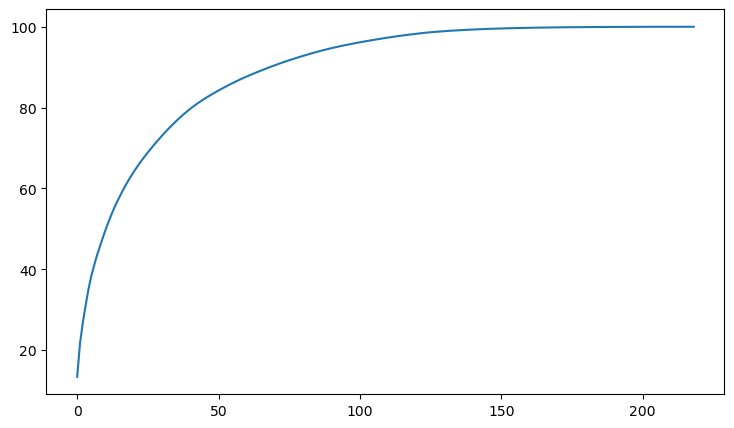

In [561]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)
plt.show()

In [562]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),("pca", PCA(n_components=PCA_VARS)),("logistic", LogisticRegression(class_weight='balanced'))]
pipeline = Pipeline(steps)

In [565]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.9857135758298549

In [566]:
# predicting churn on test data
y_pred = pipeline.predict(X_test)

# creating confusion matrix
print(confusion_matrix(y_test, y_pred))

# checking sensitivity and specificity
from imblearn.metrics import sensitivity_specificity_support
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# checking area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6532  176]
 [   6  183]]
Sensitivity: 	0.97
Specificity: 	0.97
AUC:    	 0.99


### Hyperparameter tuning

In [567]:
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

In [568]:
steps = [("scaler", StandardScaler()),("pca", PCA()),("logistic", logistic)]

In [569]:
# Compiling them
pca_logistic = Pipeline(steps)

In [570]:
param = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.4, 0.5], 'logistic__penalty': ['l1', 'l2']}

In [571]:
# 5Folds
fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20)

In [572]:
# Model
model = GridSearchCV(estimator = pca_logistic, cv = fold, param_grid = param, scoring='roc_auc', n_jobs=-1, verbose=1)

In [573]:
# fitting the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.4, 0.5],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [574]:
# cross validation
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.013955,0.432441,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,19.673841,0.240354,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,13.759036,5.631613,0.191972,0.034908,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.995210,0.995285,0.994438,0.995993,0.995060,0.995197,0.000497,6
3,11.022194,0.541697,0.229796,0.015098,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.995639,0.995716,0.994932,0.996348,0.995806,0.995688,0.000452,3
4,6.976491,0.566311,0.000000,0.000000,0.4,l1,60,"{'logistic__C': 0.4, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
5,7.593697,0.772834,0.000000,0.000000,0.4,l1,80,"{'logistic__C': 0.4, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,9.397908,0.430808,0.193462,0.047710,0.4,l2,60,"{'logistic__C': 0.4, 'logistic__penalty': 'l2'...",0.994924,0.995641,0.994915,0.995555,0.995419,0.995291,0.000311,4
7,11.672224,1.174947,0.344923,0.303251,0.4,l2,80,"{'logistic__C': 0.4, 'logistic__penalty': 'l2'...",0.996174,0.996168,0.995647,0.996577,0.996489,0.996211,0.000326,2
8,6.383866,0.853617,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
9,7.089377,0.889293,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [575]:
# best hyperparameters score
model.best_score_

0.9963316419587487

In [576]:
# best hyperparameters
model.best_params_

{'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 80}

In [577]:
# predicting churn on test data
y_pred = model.predict(X_test)

# creating onfusion matrix
print(confusion_matrix(y_test, y_pred))

# checking sensitivity and specificity
from imblearn.metrics import sensitivity_specificity_support
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# checking area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),3))

[[6454  254]
 [   4  185]]
Sensitivity: 	0.98
Specificity: 	0.96
AUC:    	 0.995


In [578]:
frt = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

In [579]:
param = {"criterion": ['gini', 'entropy'], "max_features": [1]}

In [580]:
# creating folds
fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20)

In [581]:
# Grid search
model = GridSearchCV(estimator=frt, cv=fold, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=1)

In [582]:
# fitting the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_features': [1]},
             scoring='roc_auc', verbose=1)

In [583]:
# best hyperparameters score
model.best_score_

0.9999993702796146

In [584]:
# best hyperparameters
model.best_params_

{'criterion': 'entropy', 'max_features': 1}

In [585]:
# predicting churn on test data
y_pred = model.predict(X_test)

# creating onfusion matrix
print(confusion_matrix(y_test, y_pred))

# checking sensitivity and specificity
from imblearn.metrics import sensitivity_specificity_support
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# checking area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6702    6]
 [  10  179]]
Sensitivity: 	0.95
Specificity: 	1.0
AUC:    	 1.0


In [586]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))
rand_frt_model = RandomForestClassifier(n_estimators=100, max_features = max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=20, verbose=1)

In [587]:
# fiting the model
rand_frt_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.3s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=15,
                       oob_score=True, random_state=20, verbose=1)

In [588]:
# checking OOB score
rand_frt_model.oob_score_

1.0

In [589]:
# predicting churn on test data
y_pred = rand_frt_model.predict(X_test)

# creating onfusion matrix
print(confusion_matrix(y_test, y_pred))

# checking sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# checking area under curve
y_pred_prob = rand_frt_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[6707    1]
 [   1  188]]
Sensitivity: 	0.99
Specificity: 	1.0
ROC:    	 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [590]:
# predictors
feature = high_val_cust.drop('churn', axis=1).columns

In [591]:
# feature_importance
importance = rand_frt_model.feature_importances_

In [592]:
# creating the dataframe
feature_imp = pd.DataFrame({'variables': feature, 'importance_percentage': importance*100})
feature_imp = feature_imp[['variables', 'importance_percentage']]

In [593]:
# sorting the features
feature_imp = feature_imp.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_imp.importance_percentage.sum())
feature_imp

Sum of importance= 100.00000000000001


,variables,importance_percentage
0,loc_ic_t2m_mou_9,8.402009
1,loc_og_t2t_mou_9,7.670031
2,total_ic_mou_9,7.391224
3,loc_ic_mou_9,6.715051
4,roam_ic_mou_9,6.588127
...,...,...
214,std_og_t2c_mou_7,0.000000
215,std_og_t2c_mou_6,0.000000
216,std_og_t2f_mou_8,0.000000
217,loc_ic_t2o_mou,0.000000


In [594]:
# extract top 'n' features
top_features = feature_imp.variables[0:50]

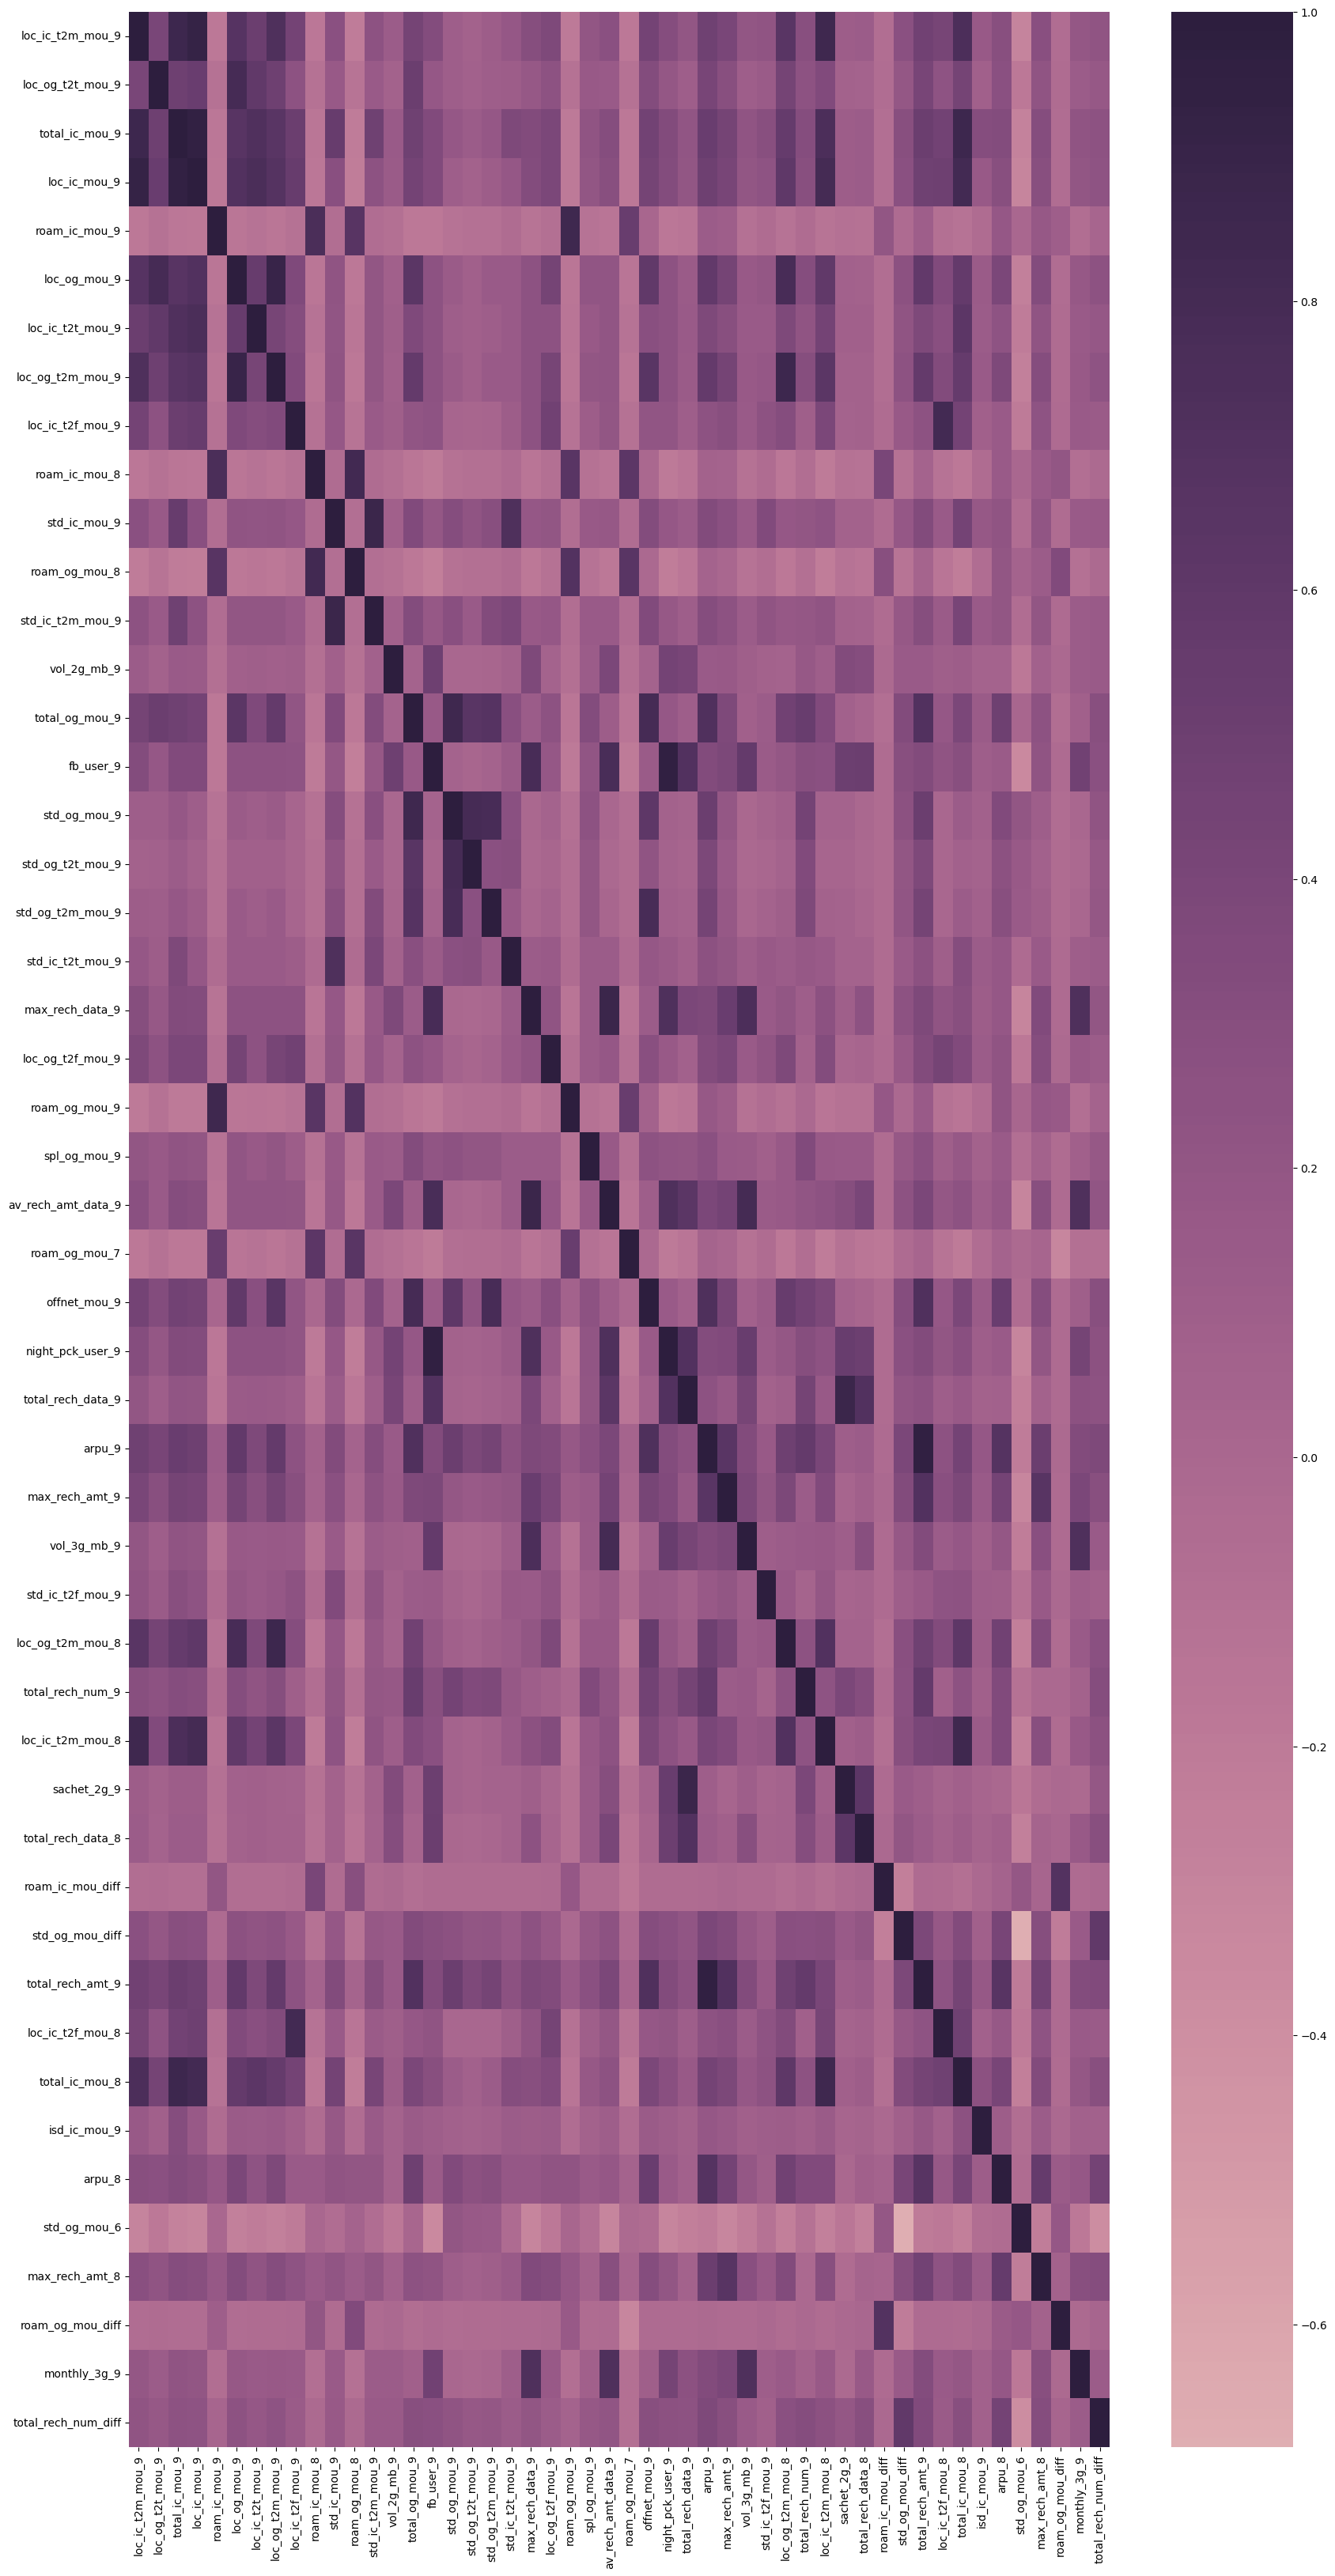

In [595]:
# plot feature correlation
plt.figure(figsize = (20,40))
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0,cmap= sns.cubehelix_palette(200))
plt.show()

In [596]:
# Selecting features that are relevent
top_features = ['total_ic_mou_8', 'total_rech_amt_diff', 'total_og_mou_8', 'arpu_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'std_ic_mou_8', 'av_rech_amt_data_8', 'std_og_mou_8']
X_train = X_train[top_features]
X_test = X_test[top_features]

In [597]:
# logistic regression
step = [('scaler', StandardScaler()),("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))]

# compiling
logistic = Pipeline(step)

# hyperparameter
param = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# 5 folds
fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# creating gridsearch
model = GridSearchCV(estimator = logistic, cv = fold, param_grid = param, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [598]:
# fitting the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [599]:
# best hyperparameters score
model.best_score_

0.9302430910160349

In [600]:
# best hyperparameters
model.best_params_

{'logistic__C': 0.1, 'logistic__penalty': 'l2'}

In [601]:
# predicting churn on test data
y_pred = model.predict(X_test)

# creating onfusion matrix
print(confusion_matrix(y_test, y_pred))

# checking sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# checking area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[3556 3152]
 [   7  182]]
Sensitivity: 	0.96
Specificity: 	0.53
ROC:    	 0.9


In [602]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [603]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [604]:
# coefficients
coefficient = logistic_model.coef_.reshape((9, 1)).tolist()
coefficient = [val for sublist in coefficient for val in sublist]
coefficient = [round(coefficient, 3) for coefficient in coefficient]
logistic_feature = list(X_train.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_feature)

In [605]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_ic_mou_8,total_rech_amt_diff,total_og_mou_8,arpu_8,roam_ic_mou_8,roam_og_mou_8,std_ic_mou_8,av_rech_amt_data_8,std_og_mou_8
0,1.790587,-1.510452,-0.579806,-1.262181,-0.307721,0.607999,1.44576,0.103405,-0.912135,1.66172


### Main indicator of churn

From above it is clear that the factors affecting the churn are:
- total_ic_mou_8 (Total incoming call: Minutes of usage in the action phase)
- total_rech_amt_diff (Total recharge amount difference)
- total_og_mou_8 (Total outgoing call: Minutes of usage in the action phase) 
- arpu (Average revenue per user)
- roam_ic_mou_8 (Roaming incoming call: Minutes of usage in the action phase)
- roam_og_mou_8 (Roaming outgoing call: Minutes of usage in the action phase) 
- std_ic_mou_8(STD incoming call: Minutes of usage in the action phase)
- std_og_mou_8 (STD outgoing call: Minutes of usage in the action phase)
- av_rech_amt_data_8(average recharge amount in the action phase)

### Steps to help reduce churn

- Give special; discounts to customers according to their usage

- Provide additional internet services on recharge.

- Speak to customers to fulfil their desires.

- Lower tariffs on data usage,a better 2G area coverage where 3G is not available.

- Expansion of 3G network where 3G is currently not available.